# Results Assessment Weather Data

- The feature "snow" shall be deleted from all weather stations
- The following weather stations shall be deleted as they have a relative high amount of missing data, which cannot correctly be predicted using interpolation: '10192', '10308', '10528', '10571', '10725', '10745', '10859', '10869', '10912', '10953', 'D4878', 'EDBC0', 'EDFE0', 'EDHK0'
- Get rid of all the weather stations that only have information regarding precipitation: around 490 stations
- Use the information from near stations to predict the missing information of the around 190 stations missing 5 fitures
- The station 10837 has a couple of outliers for wdir - change it to max possible value (360)
- The station 10172 recorded wind speed of 300 Km/h which cannot be possible since the maximum wind speed ever recorded in Germany is 195 km/h
- Use the hour of the day to predict the amount of sun... if possible

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px

from meteostat import Stations

## Import Weather Data

In [5]:
path_weather = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/Data_collection_weather/data_weather/weather_data_since_2013.csv'
df_weather = pd.read_csv(path_weather)
df_weather.shape

(61392, 4911)

In [173]:
df_weather.head()

,Unnamed: 0,Unnamed: 0.1,time,10015_temp,10015_dwpt,10015_rhum,10015_prcp,10015_wdir,10015_wspd,10015_pres,...,10004_tsun,10571_pres,10571_coco,D1792_temp,D1792_dwpt,D1792_rhum,EDHK0_pres,EDHK0_coco,EDTY0_pres,EDTY0_coco
0,0,0,2013-10-26 00:00:00,15.2,13.9,92.0,0.0,210.0,26.6,1007.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2013-10-26 01:00:00,15.0,13.5,91.0,0.0,210.0,28.8,1006.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2013-10-26 02:00:00,14.9,13.4,91.0,0.0,210.0,34.6,1006.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2013-10-26 03:00:00,14.7,13.2,91.0,0.0,210.0,31.3,1006.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2013-10-26 04:00:00,14.7,13.2,91.0,0.0,210.0,30.6,1005.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Explore Fetures and Weather Stations

Get a DataFrame with all the stations and the percentage of NaN values for each feature. Features are for example temperature, wind speed etc.

In [3]:
# create an empty dataframe that will contain the relative amount of 
# nans per station and feature
df_features = pd.DataFrame(columns = ['station', 
                                            'temp', 'dwpt',
                                            'rhum', 'prcp',
                                            'snow', 'wdir',
                                            'wspd', 'wpgt',
                                            'pres', 'tsun',
                                            'coco', 'latitude',
                                            'longitude'])

In [59]:
# get the list of all stations from meteostat
stations = Stations(country = 'DE')
all_stationsDE = stations.fetch(0)

In [5]:
# append all the stations to the dataframe
df_features.loc[:,'station'] = all_stationsDE.id.values
df_features.loc[:,'latitude'] = all_stationsDE.latitude.values
df_features.loc[:,'longitude'] = all_stationsDE.longitude.values

In [6]:
# append all the percentage of nan values to the right column
length = len(df_weather)
for feature in df_features.columns[1:]:
    for i in range(len(df_features)):
        try:
            name = (df_features.iloc[i:i+1, 0].values + '_' +\
                   feature)[0]
            value = df_weather[name].isnull().sum()/length
            df_features.loc[i, feature] = value
        except:
            pass

# set index = station
df_features.set_index('station', inplace=True)
df_features.head()

,station,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,latitude,longitude
0,10004,0.619576,0.619674,0.619674,0.674274,0.999984,0.619543,0.619543,0.666536,0.619641,0.999967,0.653098,54.1667,6.3500
1,10007,0.626922,0.626955,0.626955,0.674274,NaN,0.626938,0.626922,0.668735,0.626922,0.999967,0.653098,54.1833,7.4333
2,10008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0000,6.3333
3,10015,0.00322518,0.00368126,0.00368126,0.00302971,0.799208,0.00597798,0.00703675,0.608467,0.00322518,0.156274,0.60964,54.1833,7.9000
4,10018,0.361643,0.365569,0.365569,0.653196,NaN,0.364722,0.362148,0.675707,0.509513,NaN,0.635327,54.9167,8.3500


In [7]:
# get rid of geographical outlier
df_features = df_features.drop(df_features.query('latitude < 40').index[0], axis=0)

In [12]:
# make sure everything is saved as a float
cols = df_features.columns
df_features[cols] = df_features[cols].astype('float32')

In [14]:
# Analye the relative amount of nan values per feature:
df_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,599.0,0.127286,0.242563,0.000000,0.000391,0.002362,0.030664,0.999967
dwpt,599.0,0.127695,0.242485,0.000000,0.000440,0.002688,0.034663,0.999967
rhum,599.0,0.127695,0.242485,0.000000,0.000440,0.002688,0.034663,0.999967
prcp,1064.0,0.086513,0.211015,0.000000,0.000749,0.002688,0.010384,0.967488
snow,194.0,0.829521,0.075409,0.609884,0.791711,0.796456,0.850200,0.999984
wdir,335.0,0.235791,0.294125,0.000000,0.002044,0.009513,0.608190,0.999984
wspd,335.0,0.226070,0.292520,0.000000,0.002240,0.008812,0.608182,0.999967
wpgt,270.0,0.633745,0.033944,0.608157,0.608467,0.609395,0.675658,0.781796
pres,306.0,0.266919,0.305460,0.000000,0.000949,0.008055,0.653098,0.928346
tsun,308.0,0.240405,0.148876,0.152137,0.157610,0.215956,0.228715,0.999967


**Assessment:** Three features seem to have a high number of nan's: snow, wind peak gust (wpgt) and weather condition code. This three features are thus candidates for deleting. Further evaluation necessary

In [15]:
# create a function to evaluate each feature

def explore_nans_features(df, feature):
    '''
    Find the first not-null value among all stations with the given feature,
    then choose the latest point in time when this happens and calculate how
    many missing values are there afterwards
    INPUT: dataframe with all information regarding weather (df_weather)
    OUTPUT: dataframe with the information for each station when the first 
    not-null value appears
    '''
    
    col_list = [col for col in df.columns if col[-4:] == feature]

    station_list = list()
    first_notnull = list()

    for col in col_list:
        first_notnull.append(df[col].notnull().idxmax())
        station_list.append(col)

    df_notnull = pd.DataFrame({'station':station_list, 'first_notnull':first_notnull})
    index = df_notnull.max().values[1]
    print(f'You are looking at the feature {feature}\n')
    print('You are seeing when was the first time a not nan value appear in the dataset:\n', df_notnull.describe())
    val = (df[col_list].iloc[int(index):, :].isnull().sum()/len(df[col_list].iloc[int(index):, :])).mean()
    date = df.iloc[index, 2]
    print(f'Starting from {date}, the relative amount of missing information for the feature {feature} is: {val}\n')
    return df_notnull

In [16]:
features_list = ['snow', 'wpgt', 'coco']

df_list = list()
for feature in features_list:
    df = explore_nans_features(df_weather, feature)
    df_list.append(df)

You are looking at the feature snow

You are seeing when was the first time a not nan value appear in the dataset:
        first_notnull
count     195.000000
mean    35139.466667
std       399.314764
min     35100.000000
25%     35100.000000
50%     35100.000000
75%     35102.000000
max     40461.000000
Starting from 2018-10-08 15:00:00, the relative amount of missing information for the feature snow is: 0.5828863824850639

You are looking at the feature wpgt

You are seeing when was the first time a not nan value appear in the dataset:
        first_notnull
count     271.000000
mean    35976.476015
std      1498.175035
min     35098.000000
25%     35100.000000
50%     35100.000000
75%     38534.000000
max     38537.000000
Starting from 2018-07-20 11:00:00, the relative amount of missing information for the feature wpgt is: 0.11078344867894094

You are looking at the feature coco

You are seeing when was the first time a not nan value appear in the dataset:
        first_notnull
count 

**Assessment:** 
- The feature **snow** has too many missing values. It can be deleted
- If the features wind peak gust and the weather condition code can be incorporated at a later timepoint, then there is enough information.

**Explore each weather station**

In [17]:
# create a new dataframe where the dependent variables are the features
df_stations = df_features.transpose()
df_stations.drop(labels = ['latitude', 'longitude', 'snow', 'coco', 'wpgt'], inplace=True)
df_stations = df_stations.astype('float32')

In [19]:
# get a view of all stations that have more than 40% missing values
df_describe = df_stations.describe().transpose()
df_stations[df_describe.query('mean > 0.4').index]

station,10004,10007,10018,10026,10034,10037,10044,10063,10122,10124,...,D3820,D4878,D5490,D5512,D5684,EDBC0,EDFE0,EDHK0,EDOB0,EDTY0
temp,0.619576,0.626922,0.361643,0.653196,0.653196,0.290331,0.653163,0.653163,0.653196,0.653163,...,NaN,0.507265,NaN,NaN,NaN,0.821752,0.771990,0.568918,0.561848,0.446280
dwpt,0.619674,0.626955,0.365569,0.653196,0.653196,0.290331,0.653163,0.653163,0.653196,0.653163,...,NaN,0.507265,NaN,NaN,NaN,0.821752,0.771990,0.571801,0.561848,0.448527
rhum,0.619674,0.626955,0.365569,0.653196,0.653196,0.290331,0.653163,0.653163,0.653196,0.653163,...,NaN,0.507265,NaN,NaN,NaN,0.821752,0.771990,0.571801,0.561848,0.448527
prcp,0.674274,0.674274,0.653196,0.653196,0.000928,0.653131,0.653163,0.653163,0.653196,0.653163,...,0.456085,0.507379,0.455809,0.426277,0.574163,NaN,NaN,NaN,0.559812,NaN
wdir,0.619543,0.626938,0.364722,0.653196,0.653196,0.494885,0.653163,0.653163,0.653196,0.653163,...,NaN,NaN,NaN,NaN,NaN,0.834718,0.796895,0.614445,NaN,0.577844
wspd,0.619543,0.626922,0.362148,0.653196,0.653196,0.493077,0.653163,0.653163,0.653196,0.653163,...,NaN,NaN,NaN,NaN,NaN,0.821817,0.771843,0.599866,NaN,0.480470
pres,0.619641,0.626922,0.509513,0.653196,0.653196,0.297237,0.653163,0.653163,0.653196,0.653163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.928346,NaN,0.889399
tsun,0.999967,0.999967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Stations with more than 40% missing values are "red flags" and should be analyzed closer. As before, find the latest point in time a weather station had not-null values. It could be the case, that the weather station was installed just a couple of years ago

In [20]:
# create a function to evaluate each weather station

def explore_nans_station(df, station):
    '''
    Find the first not-null value among all features for each station,
    then choose the latest point in time when this happens and calculate how
    many missing values are there afterwards
    INPUT: 
    - df: dataframe with all information regarding weather (df_weather)
    - station: name of station / station id
    OUTPUT: 
    - dataframe with the information for each station when the first 
    not-null value appears
    - station name
    - relative amount of missing values starting at the latest point in time
    where a not-null value was observed 
    '''    
    
    col_list = [col for col in df.columns if col[:5] == station]

    station_list = list()
    first_notnull = list()

    for col in col_list:
        first_notnull.append(df[col].notnull().idxmax())
        station_list.append(col)

    df_notnull = pd.DataFrame({'station':station_list, 'first_notnull':first_notnull})
    index = df_notnull.max().values[1]
    print(f'You are looking at the station {station}\n')
    print('You are seeing when was the first time a not-null value appear in the dataset:\n', df_notnull.describe())
    val = (df[col_list].iloc[int(index):, :].isnull().sum()/len(df[col_list].iloc[int(index):, :])).mean()
    date = df.iloc[index, 2]
    print(f'Starting from {date}, the relative amount of missing information for the station {station} is: {val}\n')
    return df_notnull, station, val

In [177]:
# to perform the analysis, first drop all the columns with 
# the featurs snow, wpgt, coco since these three columns have
# the most amount of nan values

drop_cols = [col for col in df_weather.columns if col[-4:] in ['snow', 'wpgt', 'coco']]
df_weather_2 = df_weather.drop(columns=drop_cols).copy()

# create a list of station and the amount of missing values
# after the first not-null value was observed
station_list = list()
val_list = list()

for station in df_describe.query('mean > 0.5').index:
    _, station, val = explore_nans_station(df_weather_2, station)
    station_list.append(station)
    val_list.append(val)

(61392, 4911)
(61392, 4911)
You are looking at the station 10004

You are seeing when was the first time a not-null value appear in the dataset:
        first_notnull
count       8.000000
mean    37771.250000
std      6378.719593
min     35088.000000
25%     35088.000000
50%     35088.000000
75%     35900.250000
max     53305.000000
Starting from 2019-11-25 01:00:00, the relative amount of missing information for the station 10004 is: 0.12496908618770868

You are looking at the station 10007

You are seeing when was the first time a not-null value appear in the dataset:
        first_notnull
count       8.000000
mean    36204.000000
std      2139.147561
min     35100.000000
25%     35100.000000
50%     35100.000000
75%     35909.250000
max     40695.000000
Starting from 2018-10-18 09:00:00, the relative amount of missing information for the station 10007 is: 0.23714185630767745

You are looking at the station 10026

You are seeing when was the first time a not-null value appear in the 

You are looking at the station 10438

You are seeing when was the first time a not-null value appear in the dataset:
        first_notnull
count        8.00000
mean         0.37500
std          1.06066
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          3.00000
Starting from 2013-10-26 03:00:00, the relative amount of missing information for the station 10438 is: 0.6943222727198683

You are looking at the station 10452

You are seeing when was the first time a not-null value appear in the dataset:
        first_notnull
count            8.0
mean         35100.0
std              0.0
min          35100.0
25%          35100.0
50%          35100.0
75%          35100.0
max          35100.0
Starting from 2018-01-27 16:00:00, the relative amount of missing information for the station 10452 is: 0.10774665297428876

You are looking at the station 10453

You are seeing when was the first time a not-null value appear in the dataset:
        first_notnul

        first_notnull
count            7.0
mean         35124.0
std              0.0
min          35124.0
25%          35124.0
50%          35124.0
75%          35124.0
max          35124.0
Starting from 2018-01-28 18:00:00, the relative amount of missing information for the station 10684 is: 0.18939393939393942

You are looking at the station 10714

You are seeing when was the first time a not-null value appear in the dataset:
        first_notnull
count       7.000000
mean    10035.428571
std     17138.757081
min         0.000000
25%         0.000000
50%         0.000000
75%     17562.000000
max     35124.000000
Starting from 2018-01-28 18:00:00, the relative amount of missing information for the station 10714 is: 0.18939393939393942

You are looking at the station 10722

You are seeing when was the first time a not-null value appear in the dataset:
        first_notnull
count            7.0
mean         35124.0
std              0.0
min          35124.0
25%          35124.0
50%      

In [179]:
# Which stations have still more than 40% of missing values
df_stations_nan_above_40 = pd.DataFrame({'station':station_list, 'nan_percentage': val_list})
df_stations_nan_above_40 = df_stations_nan_above_40.query('nan_percentage > 0.4') 
df_stations_nan_above_40

,station,nan_percentage
12,10192,0.670251
23,10308,0.414022
36,10438,0.694322
40,10466,0.502136
52,10528,0.485284
73,10725,0.999943
76,10745,0.754719
81,10838,0.581755
85,10869,0.999207
87,10912,0.977652


**Assessment:** the identified weather stations are strong candidates to be deleted. Furhter assessment necessary

In [180]:
# get a closer look to the stations:
candidates = df_stations_nan_above_40['station'].values
cols = [col for col in df_weather.columns if col[:5] in candidates]

# show the last 48 hours of each feature for each column
for col in cols:
    print(df_weather[['time', col]].tail(48))

                      time  10192_temp
61344  2020-10-25 00:00:00         NaN
61345  2020-10-25 01:00:00         NaN
61346  2020-10-25 02:00:00         NaN
61347  2020-10-25 03:00:00         NaN
61348  2020-10-25 04:00:00         NaN
61349  2020-10-25 05:00:00         NaN
61350  2020-10-25 06:00:00         NaN
61351  2020-10-25 07:00:00        11.0
61352  2020-10-25 08:00:00        12.0
61353  2020-10-25 09:00:00        13.0
61354  2020-10-25 10:00:00        14.0
61355  2020-10-25 11:00:00        14.0
61356  2020-10-25 12:00:00        14.0
61357  2020-10-25 13:00:00        14.0
61358  2020-10-25 14:00:00        14.0
61359  2020-10-25 15:00:00         NaN
61360  2020-10-25 16:00:00         NaN
61361  2020-10-25 17:00:00         NaN
61362  2020-10-25 18:00:00         NaN
61363  2020-10-25 19:00:00         NaN
61364  2020-10-25 20:00:00         NaN
61365  2020-10-25 21:00:00         NaN
61366  2020-10-25 22:00:00         NaN
61367  2020-10-25 23:00:00         NaN
61368  2020-10-26 00:00:0

61391  2020-10-26 23:00:00         8.0
                      time  EDHK0_dwpt
61344  2020-10-25 00:00:00        10.0
61345  2020-10-25 01:00:00        10.0
61346  2020-10-25 02:00:00        10.0
61347  2020-10-25 03:00:00        10.0
61348  2020-10-25 04:00:00        10.0
61349  2020-10-25 05:00:00        10.0
61350  2020-10-25 06:00:00        10.0
61351  2020-10-25 07:00:00        10.0
61352  2020-10-25 08:00:00        10.0
61353  2020-10-25 09:00:00        10.0
61354  2020-10-25 10:00:00         9.1
61355  2020-10-25 11:00:00        10.1
61356  2020-10-25 12:00:00        10.1
61357  2020-10-25 13:00:00        10.1
61358  2020-10-25 14:00:00        11.0
61359  2020-10-25 15:00:00        11.1
61360  2020-10-25 16:00:00        11.1
61361  2020-10-25 17:00:00        11.1
61362  2020-10-25 18:00:00        10.1
61363  2020-10-25 19:00:00        10.1
61364  2020-10-25 20:00:00        10.1
61365  2020-10-25 21:00:00        10.1
61366  2020-10-25 22:00:00        10.0
61367  2020-10-25 23:00:0

**Assessment:** the identified stations can be deleted as they have too many missing values during the whole time period. In some cases the weather stations only report values during a limited time of the day

In [181]:
# Show the location in the map compare to other stations
stations_to_drop = df_stations_nan_above_40.station.values
stations_to_drop = all_stationsDE.query('id in @stations_to_drop')

(1128, 9)
(15, 15)


<AxesSubplot:>

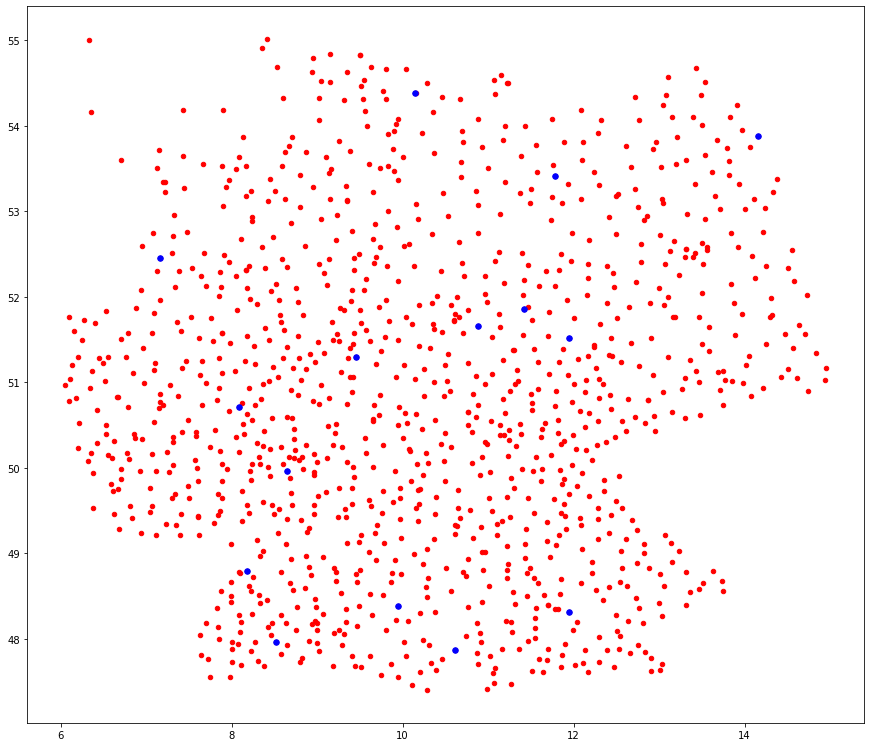

In [182]:
# Get a view of the geographical location of each weather station in GERMANY
# Change the code for a different country!
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(all_stationsDE, 
                          geometry = gpd.points_from_xy(all_stationsDE.longitude, 
                                                        all_stationsDE.latitude))
geo_df_2 = gpd.GeoDataFrame(stations_to_drop, geometry = gpd.points_from_xy(stations_to_drop.longitude,
                                                            stations_to_drop.latitude))

geo_df.drop(columns=['wmo', 
                     'icao', 
                     'elevation', 
                     'timezone', 
                     'hourly_start', 
                     'hourly_end'], inplace=True)

# Get rid of wrong labeled stations
print(geo_df.shape)
geo_df_3 = geo_df.drop(geo_df.query('latitude < 40').index)
print(geo_df_2.shape)

# create the plot
fig, ax = plt.subplots(figsize=(15,15))
geo_df_3.plot(ax=ax, markersize=20, color='red', marker = 'o')
geo_df_2.plot(ax=ax, markersize=30, color='blue', marker = 'o')

# Create an overview, which featerus should be considered starting at what point in time

So far 1 feature (snow) will be removed from all weather stations. 

Wind peak gust and weather condition can be included starting at a later point in time: end of 2018 and beginning of 2020 respectively

Next step is to identify which features are available for all weather station at what time

In [237]:
# get rid of the weather stations defined before
drop_cols = [col for col in df_weather.columns if col[-4:] == 'snow']
drop_cols_2 = [col for col in df_weather.columns if col[:5] in candidates]

df_weather_2 = df_weather.copy()
df_weather_2.drop(columns = drop_cols, inplace=True)
df_weather_2.drop(columns = drop_cols_2, inplace=True)
df_weather_2.drop(df_weather_2.filter(regex="Unname"),axis=1, inplace=True)

In [238]:
df_weather_2.shape

(61392, 4614)

In [269]:
def station_features_time_distribution(df, max_rel_num_nans):
    '''
    Return a dataframe with the date from which on, the relative number of nan values is less than a given threshold
    INPUT:
    - df: dataframe with all weather data - make sure time is the first column
    - max_rel_num_nans: number between 0 and 1 that indicates the maximal relative number of null values accepted
    OUTPUT:
    - get the dataframe with the overview of the dates, when the relative number of nan values is less than the
    given threshold
    - eval_list: ordered list of the columns for easier evaluation of the results
    '''
    
    start_time = time.time()
    
    # Create a dataframe to store the values

    eval_list = ['max_date', '75_quantile', '50_quantile', '25_quantile', 'min_date']
    #print(eval_list)
    #print(len(eval_list))
    eval_list.extend(list(set([station[:5] for station in df.columns])))
    #print(eval_list)
    #print(len(eval_list))
    feature_list = sorted(list(set([feature[-4:] for feature in df.columns])))
    df_time = pd.DataFrame(columns=eval_list, index=feature_list)
    #print(df_time.shape)
    
    # iterate through each column of the weather dataaframe
    
    for col in df.columns[1:]:
        value = df[col].isnull().sum()/len(df[col])
        for day in range(0, len(df), 24):
            if value > max_rel_num_nans:
                value = df[col].iloc[day:].isnull().sum()/len(df[col].iloc[day:])
            else:
                # store value in dataframe
                row = col[-4:]
                column = col[:5]
                date = df.iloc[day:day+1,0].values[0]
                df_time.loc[row, column] = date
                break
               
    # transform each value to a dataframe
    
    for col in df_time.columns:
        df_time[col] = pd.to_datetime(df_time[col], format='%Y-%m-%d %H:%M:%S')
        
    # get the evaluation values
    df_time['max_date'] = df_time.max(axis=1)
    df_time['75_quantile'] = df_time.quantile(0.75, axis=1, numeric_only=False)
    df_time['50_quantile'] = df_time.quantile(0.75, axis=1, numeric_only=False)
    df_time['25_quantile'] = df_time.quantile(0.75, axis=1, numeric_only=False)
    df_time['min_date'] = df_time.min(axis=1)
    
    #print(df_time.shape)
    
    print(f'creating the dataframe took {time.time() - start_time} seconds')
    
    return df_time, eval_list

In [270]:
df_time, col_list = station_features_time_distribution(df_weather_2, 0.1)

creating the dataframe took 452.91986298561096 seconds


In [271]:
df_time[col_list]

,max_date,75_quantile,50_quantile,25_quantile,min_date,10249,10452,D4637,10727,D4883,...,D4352,10406,D6313,D2947,D2850,D6270,D2159,D4132,D3540,D2822
coco,2018-07-05 10:00:00,2017-11-24 12:00:00,2017-11-24 12:00:00,2017-11-24 12:00:00,2017-08-20,2017-10-12,2017-10-12,NaT,2017-11-24 12:00:00,NaT,...,NaT,2017-11-24 12:00:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
dwpt,2020-09-20 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26,2013-10-26,2017-10-11,NaT,2017-11-24 12:00:00,NaT,...,NaT,2017-11-24 12:00:00,NaT,2013-10-26,NaT,NaT,NaT,NaT,2013-10-26,NaT
prcp,2020-09-20 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26,2013-10-26,2017-10-11,2013-10-26,2017-11-24 12:00:00,2013-10-26,...,2013-10-26,2014-09-23 00:00:00,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26
pres,2020-09-10 00:00:00,2017-11-24 12:00:00,2017-11-24 12:00:00,2017-11-24 12:00:00,2013-10-26,2013-10-26,2017-10-11,NaT,2017-11-24 12:00:00,NaT,...,NaT,2017-11-24 12:00:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
rhum,2020-09-20 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26,2013-10-26,2017-10-11,NaT,2017-11-24 12:00:00,NaT,...,NaT,2017-11-24 12:00:00,NaT,2013-10-26,NaT,NaT,NaT,NaT,2013-10-26,NaT
temp,2020-09-20 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26,2013-10-26,2017-10-11,NaT,2017-11-24 12:00:00,NaT,...,NaT,2017-11-24 12:00:00,NaT,2013-10-26,NaT,NaT,NaT,NaT,2013-10-26,NaT
time,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
tsun,2020-09-07 00:00:00,2019-03-27 00:00:00,2019-03-27 00:00:00,2019-03-27 00:00:00,2016-04-04,2016-04-27,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,2019-06-19,NaT,NaT,NaT,NaT,NaT,NaT
wdir,2018-03-18 01:00:00,2017-10-11 00:00:00,2017-10-11 00:00:00,2017-10-11 00:00:00,2013-10-26,2013-10-26,2017-10-11,NaT,2017-11-24 12:00:00,NaT,...,NaT,2017-11-24 12:00:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
wpgt,2017-11-24 12:00:00,2017-11-24 12:00:00,2017-11-24 12:00:00,2017-11-24 12:00:00,2017-10-11,2017-10-12,2017-10-12,NaT,2017-11-24 12:00:00,NaT,...,NaT,2017-11-24 12:00:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [318]:
# drop time and coco column
df_time.drop(labels=['time', 'coco'], inplace=True)
df_time.shape

(9, 1074)

In [319]:
for i in range(9):
    cols = [col for col in df_time.columns if df_time[col].isnull().sum() >= i]
    print(f'{len(cols)} number of stations are missing {i} or more features')

1074 number of stations are missing 0 or more features
905 number of stations are missing 1 or more features
787 number of stations are missing 2 or more features
770 number of stations are missing 3 or more features
761 number of stations are missing 4 or more features
684 number of stations are missing 5 or more features
490 number of stations are missing 6 or more features
488 number of stations are missing 7 or more features
488 number of stations are missing 8 or more features


In [320]:
cols = [col for col in df_time.columns if df_time[col].isnull().sum() >= 6]

(1128, 9)
(489, 15)


<AxesSubplot:>

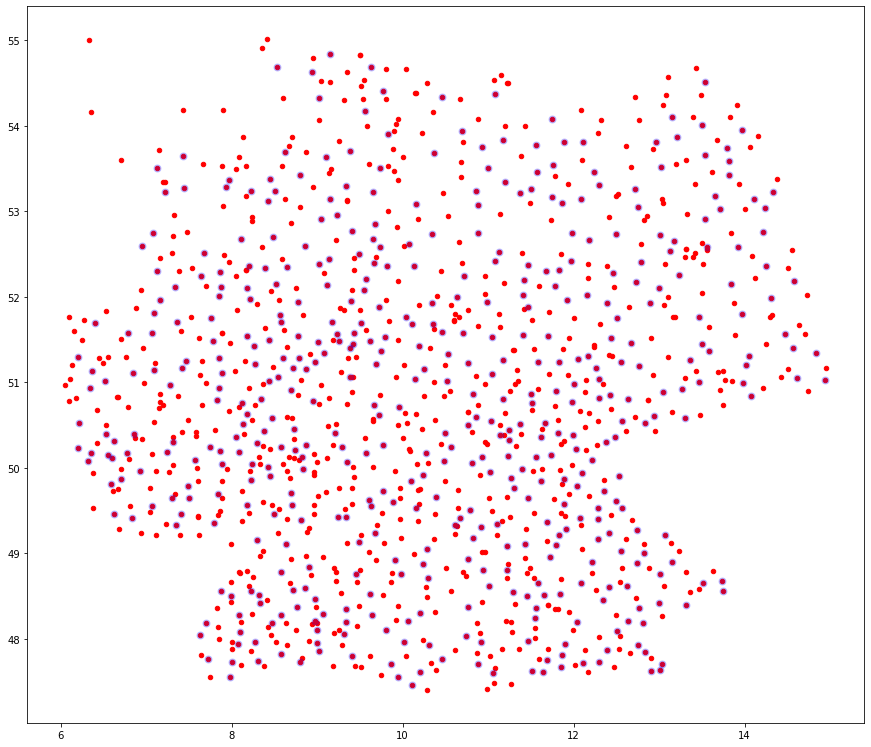

In [321]:
# Get a view of the geographical location of each weather station in Germany

# Show the location in the map compare to other stations
stations_to_drop = cols
stations_to_drop = all_stationsDE.query('id in @stations_to_drop')

crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(all_stationsDE, 
                          geometry = gpd.points_from_xy(all_stationsDE.longitude, 
                                                        all_stationsDE.latitude))
geo_df_2 = gpd.GeoDataFrame(stations_to_drop, geometry = gpd.points_from_xy(stations_to_drop.longitude,
                                                            stations_to_drop.latitude))

geo_df.drop(columns=['wmo', 
                     'icao', 
                     'elevation', 
                     'timezone', 
                     'hourly_start', 
                     'hourly_end'], inplace=True)

# Get rid of wrong labeled stations
print(geo_df.shape)
geo_df_3 = geo_df.drop(geo_df.query('latitude < 40').index)
print(geo_df_2.shape)

# create the plot
fig, ax = plt.subplots(figsize=(15,15))
geo_df_3.plot(ax=ax, markersize=20, color='red', marker = 'o')
geo_df_2.plot(ax=ax, markersize=50, color='blue', marker = 'o', alpha=0.2)

(1128, 9)
(639, 15)


<AxesSubplot:>

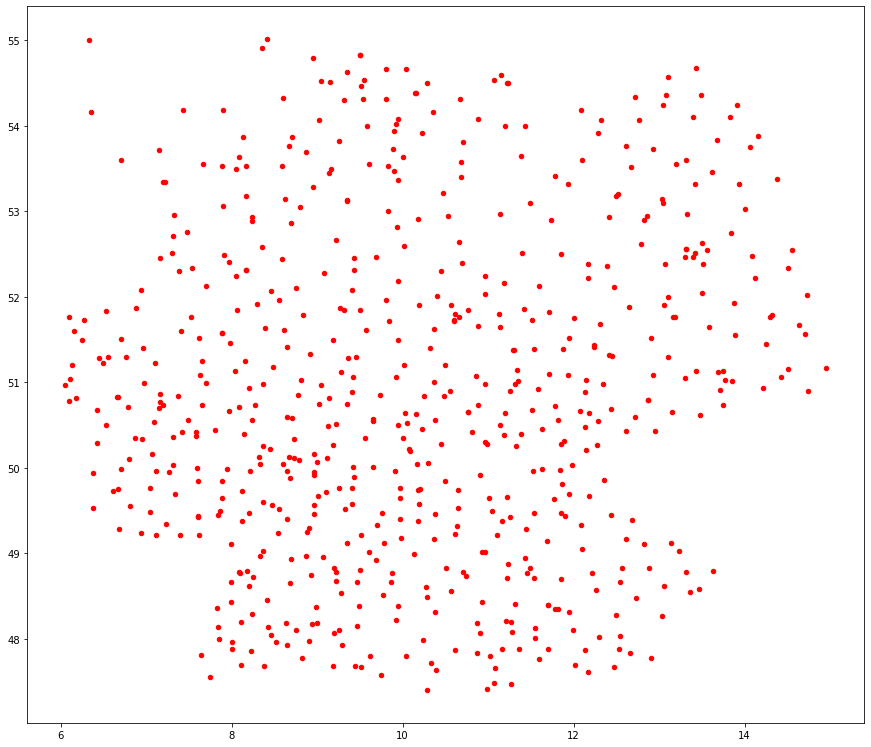

In [322]:
# Get a view of the geographical location of each weather station in Germany

# Show the location in the map compare to other stations
stations_to_drop = cols
stations_to_drop = all_stationsDE.query('id not in @stations_to_drop')

crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(all_stationsDE, 
                          geometry = gpd.points_from_xy(all_stationsDE.longitude, 
                                                        all_stationsDE.latitude))
geo_df_2 = gpd.GeoDataFrame(stations_to_drop, geometry = gpd.points_from_xy(stations_to_drop.longitude,
                                                            stations_to_drop.latitude))

geo_df.drop(columns=['wmo', 
                     'icao', 
                     'elevation', 
                     'timezone', 
                     'hourly_start', 
                     'hourly_end'], inplace=True)

# Get rid of wrong labeled stations
print(geo_df.shape)
geo_df_3 = geo_df_2.drop(geo_df_2.query('latitude < 40').index)
print(geo_df_2.shape)

# create the plot
fig, ax = plt.subplots(figsize=(15,15))
geo_df_3.plot(ax=ax, markersize=20, color='red', marker = 'o')
#geo_df_2.plot(ax=ax, markersize=50, color='blue', marker = 'o', alpha=0.2)

In [323]:
df_time_more_than_2_features = df_time.drop(columns=cols)

# recalculate the max, quantiles and min:

df_time_more_than_2_features['max_date'] = df_time_more_than_2_features.max(axis=1)
df_time_more_than_2_features['75_quantile'] = df_time_more_than_2_features.quantile(0.75, axis=1, numeric_only=False)
df_time_more_than_2_features['50_quantile'] = df_time_more_than_2_features.quantile(0.75, axis=1, numeric_only=False)
df_time_more_than_2_features['25_quantile'] = df_time_more_than_2_features.quantile(0.75, axis=1, numeric_only=False)
df_time_more_than_2_features['min_date'] = df_time_more_than_2_features.min(axis=1)

df_time_more_than_2_features

,max_date,75_quantile,50_quantile,25_quantile,min_date,10249,10452,10727,D2597,D3319,...,D2629,10325,D1161,D3975,D2627,D2704,D6312,10406,D2947,D3540
dwpt,2020-09-20 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26,2013-10-26,2017-10-11,2017-11-24 12:00:00,2013-10-26,2013-10-26,...,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2017-11-24 12:00:00,2013-10-26,2013-10-26
prcp,2020-09-20 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26,2013-10-26,2017-10-11,2017-11-24 12:00:00,2013-10-26,2013-10-26,...,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2014-09-23 00:00:00,2013-10-26,2013-10-26
pres,2020-09-10 00:00:00,2017-11-24 12:00:00,2017-11-24 12:00:00,2017-11-24 12:00:00,2013-10-26,2013-10-26,2017-10-11,2017-11-24 12:00:00,2013-10-26,NaT,...,NaT,2013-10-26,NaT,NaT,NaT,NaT,NaT,2017-11-24 12:00:00,NaT,NaT
rhum,2020-09-20 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26,2013-10-26,2017-10-11,2017-11-24 12:00:00,2013-10-26,2013-10-26,...,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2017-11-24 12:00:00,2013-10-26,2013-10-26
temp,2020-09-20 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26 00:00:00,2013-10-26,2013-10-26,2017-10-11,2017-11-24 12:00:00,2013-10-26,2013-10-26,...,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2013-10-26,2017-11-24 12:00:00,2013-10-26,2013-10-26
tsun,2020-09-07 00:00:00,2019-03-27 00:00:00,2019-03-27 00:00:00,2019-03-27 00:00:00,2016-04-04,2016-04-27,NaT,NaT,2019-03-14,NaT,...,NaT,NaT,NaT,NaT,2019-03-07,NaT,2019-08-27,NaT,2019-06-19,NaT
wdir,2018-03-18 01:00:00,2017-10-11 00:00:00,2017-10-11 00:00:00,2017-10-11 00:00:00,2013-10-26,2013-10-26,2017-10-11,2017-11-24 12:00:00,2013-10-26,NaT,...,NaT,2013-10-26,NaT,NaT,NaT,NaT,NaT,2017-11-24 12:00:00,NaT,NaT
wpgt,2017-11-24 12:00:00,2017-11-24 12:00:00,2017-11-24 12:00:00,2017-11-24 12:00:00,2017-10-11,2017-10-12,2017-10-12,2017-11-24 12:00:00,NaT,NaT,...,NaT,2017-10-12,NaT,NaT,NaT,NaT,NaT,2017-11-24 12:00:00,NaT,NaT
wspd,2018-03-17 01:00:00,2017-10-11 00:00:00,2017-10-11 00:00:00,2017-10-11 00:00:00,2013-10-26,2013-10-26,2017-10-11,2017-11-24 12:00:00,2013-10-26,NaT,...,NaT,2013-10-26,NaT,NaT,NaT,NaT,NaT,2017-11-24 12:00:00,NaT,NaT


In [336]:
cols_2 = [col for col in df_time.columns if df_time[col].isnull().sum() == 5]

for i in range(0, len(cols_2), 20):
    print(df_time[cols_2].notnull())

      D3319  D0259  D3527  D4857  EDOB0  D3545  D2968  10571  D0078  D4480  \
dwpt   True   True   True   True   True   True   True   True   True   True   
prcp   True   True   True   True   True   True   True  False   True   True   
pres  False  False  False  False  False  False  False   True  False  False   
rhum   True   True   True   True   True   True   True   True   True   True   
temp   True   True   True   True   True   True   True   True   True   True   
tsun  False  False  False  False  False  False  False  False  False  False   
wdir  False  False  False  False  False  False  False  False  False  False   
wpgt  False  False  False  False  False  False  False  False  False  False   
wspd  False  False  False  False  False  False  False  False  False  False   

      ...  D3670  D0390  D3679  D0617  D1721  D2629  D1161  D3975  D2704  \
dwpt  ...   True   True   True   True   True   True   True   True   True   
prcp  ...   True   True   True   True   True   True   True   True  

In [340]:
cols_3 = [col for col in df_time.columns if df_time[col].isnull().sum() >= 5]

print(len(cols_2))
print(len(cols_3))

194
684


(445, 9)
(194, 15)


<AxesSubplot:>

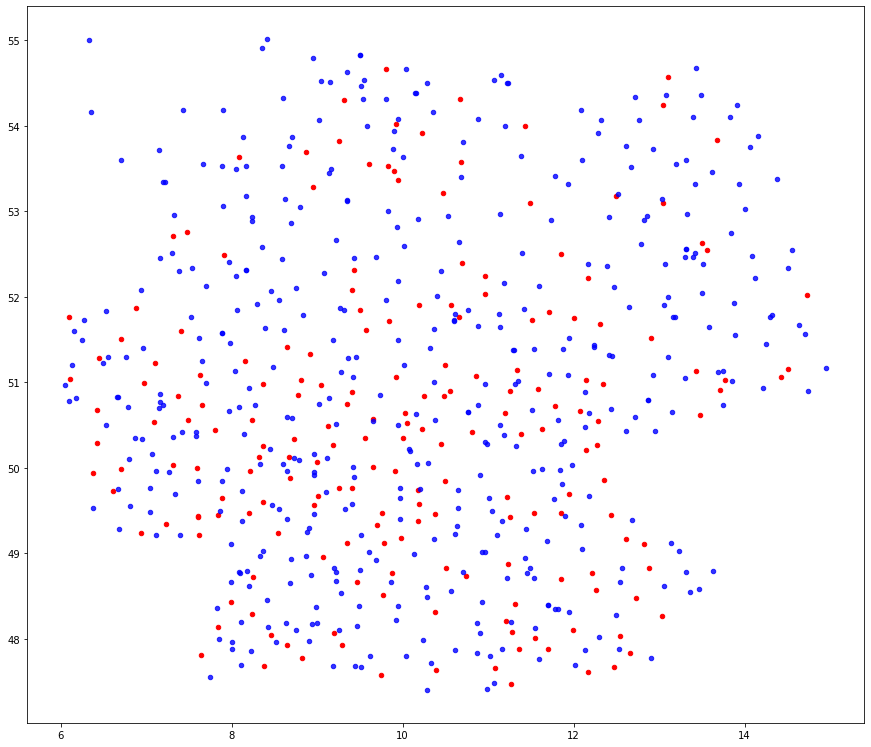

In [342]:
# Get a view of the geographical location of each weather station in Germany

# Show the location in the map compare to other stations
stations_to_drop = cols_2
stations_to_drop = all_stationsDE.query('id in @stations_to_drop')

variable = all_stationsDE.query('id not in @cols_3')

crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(variable, 
                          geometry = gpd.points_from_xy(variable.longitude, 
                                                        variable.latitude))
geo_df_2 = gpd.GeoDataFrame(stations_to_drop, geometry = gpd.points_from_xy(stations_to_drop.longitude,
                                                            stations_to_drop.latitude))

geo_df.drop(columns=['wmo', 
                     'icao', 
                     'elevation', 
                     'timezone', 
                     'hourly_start', 
                     'hourly_end'], inplace=True)

# Get rid of wrong labeled stations
print(geo_df.shape)
geo_df_3 = geo_df_2.drop(geo_df_2.query('latitude < 40').index)
geo_df_4 = geo_df.drop(geo_df.query('latitude < 40').index)
print(geo_df_2.shape)

# create the plot
fig, ax = plt.subplots(figsize=(15,15))
geo_df_3.plot(ax=ax, markersize=20, color='red', marker = 'o')
geo_df_4.plot(ax=ax, markersize=20, color='blue', marker = 'o', alpha=0.8)

# Prepare weather data for transformation

In [89]:
# load weather data again
path_weather = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/Data_collection_weather/data_weather/weather_data_since_2013.csv'
df_weather = pd.read_csv(path_weather)
df_weather.shape

(61392, 4911)

In [90]:
# get rid of snow, coco and wpgt

f_to_drop = ['snow', 'wpgt', 'coco', 'dwpt']
cols_to_drop = [col for col in df_weather.columns if col[-4:] in f_to_drop]
df_weather.drop(columns=cols_to_drop, inplace=True)
df_weather.shape

(61392, 3556)

In [91]:
# get rid of weather stations with nan values above 40%, even after the first 
# recordings started

s_to_drop = ['10192', '10308', '10528', 
             '10571', '10725', '10745', 
             '10859', '10869', '10912', 
             '10953', 'D4878', 'EDBC0', 'EDFE0', 'EDHK0']
cols_to_drop = [col for col in df_weather.columns if col[:5] in s_to_drop]
df_weather.drop(columns=cols_to_drop, inplace=True)
df_weather.shape

(61392, 3494)

In [92]:
# drop unnamed columns

df_weather.drop(df_weather.filter(regex="Unname"),axis=1, inplace=True)
df_weather.shape

(61392, 3492)

In [93]:
# get rid of outliers

# wind direction cannot be higher than 360 degrees 
df_weather.loc[df_weather['10837_wdir'] > 360, '10837_wdir'] = 360

# germany has never recorded wind speeds above 195 km/h. Set max value to 220 km/h
df_weather.loc[df_weather['10172_wspd'] > 200, '10172_wspd'] = 200

In [6]:
# get the day ahead load file to merge the data into the right timestamps

path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
file_load = 'Data_collection_entsoe/Day_ahead_dataset.csv'
df_load = pd.read_csv(path+file_load)

df_load = df_load.loc[:, ['Date', 'index']]
df_load.shape

(204096, 2)

In [96]:
# get the datetime columns to the right format

df_weather.time = pd.to_datetime(df_weather.time, format='%Y-%m-%d %H:%M:%S')
df_load.Date = pd.to_datetime(df_load.Date, format='%Y-%m-%d %H:%M:%S')

In [97]:
# merge and get rid of the index column

df_weather = df_load.merge(df_weather, left_on='Date', right_on='time', how='left')
df_weather.drop(columns=['index', 'time'], inplace=True)
df_weather.shape

(204096, 3492)

In [98]:
# use linear interpolation to fill in gaps

df_weather = df_weather.interpolate(method='linear', limit_direction='forward')

In [365]:
# normalize data min max scaler. For temperature shift all values to get only positive 
# normalized values

def min_max_normalize(df, cols_to_not_normalize):
    # fix the min and max according to phisical properties:
    feature_range_dict = dict()
    feature_range_dict['temp'] = [-50, 50] # highest temperatures ever recorded in germany
    feature_range_dict['rhum'] = [0, 110]
    feature_range_dict['prcp'] = [0, 350]
    feature_range_dict['wdir'] = [0, 360]
    feature_range_dict['wspd'] = [0, 200]
    feature_range_dict['pres'] = [0, 2000]
    feature_range_dict['tsun'] = [0, 60]
    
    cols = df.drop(columns=cols_to_not_normalize).columns
    
    for col in cols:
        X_min = feature_range_dict[col[-4:]][0]
        X_max = feature_range_dict[col[-4:]][1]

        df[col] = (df[col] - X_min)/(X_max - X_min)
    
    return df

In [102]:
df_weather_normalized = min_max_normalize(df_weather, ['Date'])

In [103]:
df_weather_normalized

,Date,10015_temp,10015_rhum,10015_prcp,10015_wdir,10015_wspd,10015_pres,10015_tsun,10018_temp,10018_rhum,...,D0760_temp,D0760_rhum,D0760_prcp,D5538_wdir,D5538_wspd,D5684_prcp,10004_tsun,D1792_temp,D1792_rhum,EDTY0_pres
0,2014-12-31 23:00:00,0.5690,0.809091,0.0,0.694444,0.194500,0.515200,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-31 23:15:00,0.5685,0.811364,0.0,0.687500,0.189500,0.515162,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-31 23:30:00,0.5680,0.813636,0.0,0.680556,0.184500,0.515125,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-31 23:45:00,0.5675,0.815909,0.0,0.673611,0.179500,0.515088,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 00:00:00,0.5670,0.818182,0.0,0.666667,0.174500,0.515050,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204091,2020-10-26 21:45:00,0.6110,0.736364,0.0,0.583333,0.202375,0.499375,0.0,0.61,0.745455,...,0.57275,0.804545,0.0,0.375000,0.022625,0.0,0.0,0.58875,0.745455,0.5045
204092,2020-10-26 22:00:00,0.6110,0.736364,0.0,0.583333,0.201500,0.499350,0.0,0.61,0.745455,...,0.57300,0.800000,0.0,0.361111,0.023500,0.0,0.0,0.58900,0.745455,0.5045
204093,2020-10-26 22:15:00,0.6110,0.736364,0.0,0.583333,0.201500,0.499350,0.0,0.61,0.745455,...,0.57300,0.800000,0.0,0.361111,0.023500,0.0,0.0,0.58900,0.745455,0.5045
204094,2020-10-26 22:30:00,0.6110,0.736364,0.0,0.583333,0.201500,0.499350,0.0,0.61,0.745455,...,0.57300,0.800000,0.0,0.361111,0.023500,0.0,0.0,0.58900,0.745455,0.5045


In [111]:
def create_feature_channels(df,stations,lat_steps,lon_steps,features,fillvalue=np.nan):
    '''
    This function will create "Pictures" where the pictures of the image correspond to the geographical location based on latitude and longitude 
    The value of each pixel corresponst to the value of the feature for that channel
    
    Parameters
    ----------
    df : TYPE
        df containing the features for different tables, named according to our convention
    stations : TYPE
        a dataframe containing the id and latitude and longitude of the stations used
    lat_steps : TYPE
        amouunt indicates the amount of pixels in the y-direction
    lon_steps : TYPE
        amouunt indicates the amount of pixels in the x-direction
    features : TYPE
        a list of features we want to include as feature channels

    Returns
    -------
    a 4d tensor, the first 2 dimensions are the lat and lon, the 3rd dimension corresponds to the feature channels, and the fourth is time

    '''
    lat_range = [47.3,55]
    lon_range = [5.625,15]
    stepsize_lat = (lat_range[-1]-lat_range[0])/(lat_steps-1)
    stepsize_lon = (lon_range[-1]-lon_range[0])/(lon_steps-1)
    
    amount_of_features = len(features)    
    time_steps = df.shape[0]    
    feature_channels = np.zeros((lat_steps, 
                                 lon_steps,
                                 amount_of_features,
                                 time_steps), "float32")*fillvalue
    
    for i in range(lat_steps):
        for j in range(lon_steps):
            lat_sub = [lat_range[0]+stepsize_lat*i,lat_range[0]+stepsize_lat*(i+1)]
            lon_sub = [lon_range[0]+stepsize_lon*j,lon_range[0]+stepsize_lon*(j+1)]
            
    
            select_stations = (stations.latitude > lat_sub[0]) & (stations.latitude <= lat_sub[1]) \
                                &(stations.longitude > lon_sub[0]) & (stations.longitude <= lon_sub[1])
            station_string = ""
            for k in stations.loc[select_stations,"id"]:
                station_string += k +"|"
    
            for cnt,l in enumerate(features):
                if (len(station_string)>1):
                    if (df.filter(regex=station_string[:-1]).filter(regex=l).shape[1]>0):
                        feature_channels[i,j,cnt,:] = df.filter(regex=station_string[:-1]).filter(regex=l).mean(axis=1)

    
    return feature_channels

In [ ]:
# import the list of all weather stations and their coordinates
stations = Stations(country = 'DE')
all_stationsDE = stations.fetch(0)

In [153]:
weather_features = ['temp', 'rhum', 'prcp', 'wdir',
            'wspd', 'pres', 'tsun']


# generate all the pictures for weather

lat_pixel = [16, 32, 16, 14, 28, 56]
lon_pixel = [10, 20, 16, 10, 20, 40]
path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/Data_collection_weather/'

for lat, lon in zip(lat_pixel,lon_pixel):
    print(f'saving weather_channels_{lat}x{lon}...\n')
    weather_channel = create_feature_channels(df_weather, 
                                          all_stationsDE,
                                          lat,
                                          lon,
                                          weather_features,
                                          fillvalue=np.nan)
    np.save(path+f'weather_channels_{lat}x{lon}', weather_channel, allow_pickle=False)

<AxesSubplot:>

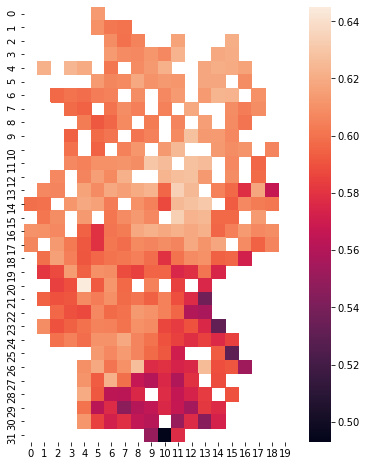

In [141]:
# plot one example of the saved data (temperature at timestamp 204,000)
plt.figure(figsize=(6,8))
sns.heatmap(weather_channels_56x40[::-1,:,0, 204000])